## Regional Analysis

In [341]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj
import gzip
import rasterio
import climate_indices
import spei
import fsspec
import netCDF4
import h5py
from rasterio.plot import show
import spei as si
import pandas as pd

In [342]:
def plot_time_series(mask, var_ds, var_name, y_label, x_label1,x_title1, x_label2,x_title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    region_1 = var_ds.where(mask==1, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_2 = var_ds.where(mask==2, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_3 = var_ds.where(mask==3, other=np.nan)[var_name].mean(dim=('lon', 'lat'))

    x = var_ds.time
    plot_3regions(x, ax1, region_1, region_2, region_3)
    ax1.set_xlabel(x_label1)
    ax1.set_ylabel(y_label)
    ax1.set_title(x_title1)
    ax1.legend()

    summer_months = var_ds.sel(time=var_ds.time.dt.month.isin([6,7])).resample(time="Y").mean()
    region_1 = summer_months.where(mask==1, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_2 = summer_months.where(mask==2, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_3 = summer_months.where(mask==3, other=np.nan)[var_name].mean(dim=('lon', 'lat'))

    x=summer_months.time
    plot_3regions(x, ax2, region_1, region_2, region_3)
    ax2.set_xlabel(x_label2)
    ax2.set_ylabel(y_label)
    ax2.set_title(x_title2)

def plot_3regions(time, axis, region_1, region_2, region_3):
    x=time
    axis.plot(x, region_3, marker='o', label="Frankenwald", color="#fde725")
    axis.plot(x, region_2, marker='o', label="Thüringer Schiefergebirge", color="#21918c")
    axis.plot(x, region_1, marker='o', label="Thüringer Wald", color="#440154")

#### Regions masks



In [343]:
path = '/work/users/my982hzao/'
ds_CF_20 = xr.open_zarr(fsspec.get_mapper(path + 'Climate_variables/soil_moisture_masked.zarr/'),
                  consolidated=True)

mask = ds_CF_20["mask"]
mask = mask.rename({"lon": "x", "lat": "y"})
mask.rio.write_crs("EPSG:4326", inplace=True)
  

<xarray.DataArray 'mask' (y: 77, x: 120)>
dask.array<open_dataset-5c75d5986a4445ac0443b46d4e91bc7emask, shape=(77, 120), dtype=float64, chunksize=(77, 120), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 51.0 50.99 50.98 50.97 ... 50.34 50.33 50.32 50.31
  * x            (x) float64 10.29 10.3 10.32 10.33 ... 11.96 11.97 11.99 12.0
    spatial_ref  int64 0

#### 2. Climate Indices 
##### a. Temperature

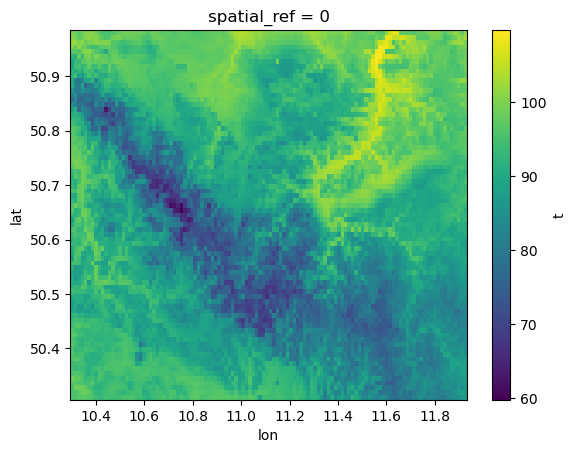

In [344]:
temp_ds = xr.open_zarr(fsspec.get_mapper(path + 'temperature_UTM.zarr/'), consolidated=True)
temp_utm = temp_ds
temp_utm.rio.write_crs("EPSG:4326", inplace=True)
mask_reprojected = mask.rio.reproject_match(temp_utm.rename({"lon": "x", "lat": "y"})).rename({"x": "lon", "y": "lat"})

temp_utm.t.mean(dim='time').plot()

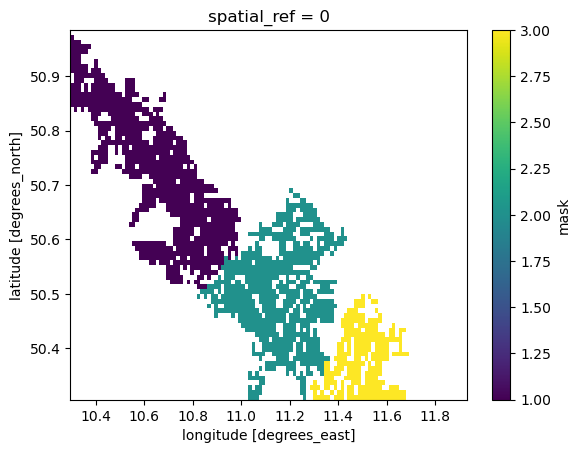

In [345]:
mask_reprojected.plot()

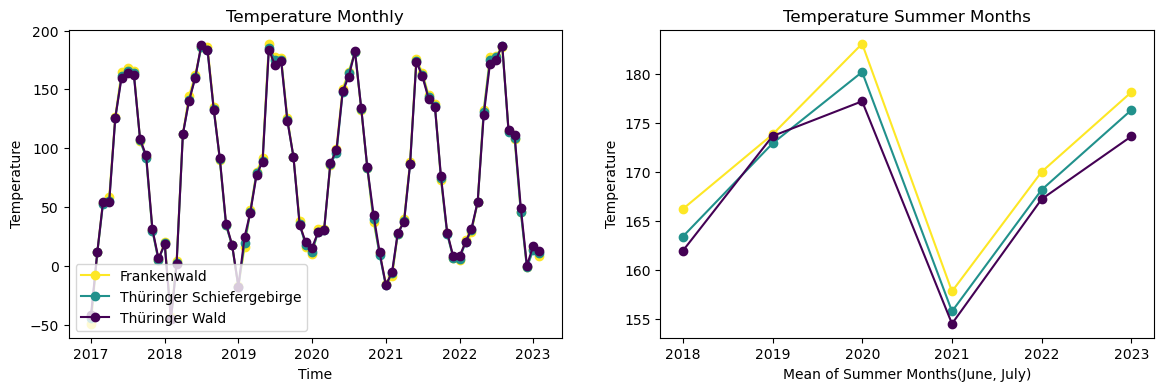

In [346]:
plot_time_series(mask_reprojected, temp_ds, "t", "Temperature","Time",'Temperature Monthly',"Mean of Summer Months(June, July)", 'Temperature Summer Months')

##### b. Soil Moisture

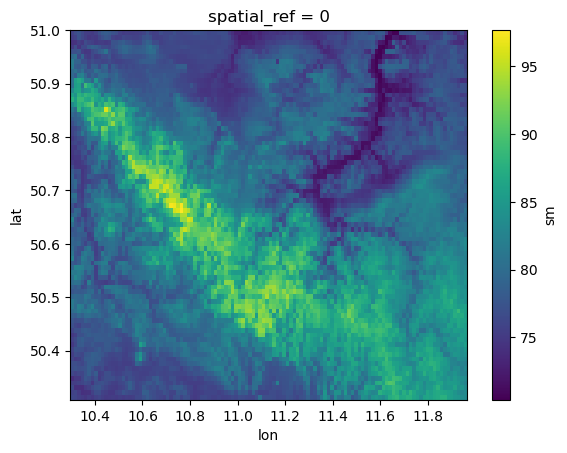

In [347]:
sm_ds = xr.open_zarr(fsspec.get_mapper(path + 'soil_moisture_monthly_UTM.zarr/'), consolidated=True)
sm_utm = sm_ds
sm_utm.rio.write_crs("EPSG:4326", inplace=True)
mask_reprojected = mask.rio.reproject_match(sm_utm.rename({"lon": "x", "lat": "y"})).rename({"x": "lon", "y": "lat"})

sm_utm.sm.mean(dim='time').plot()

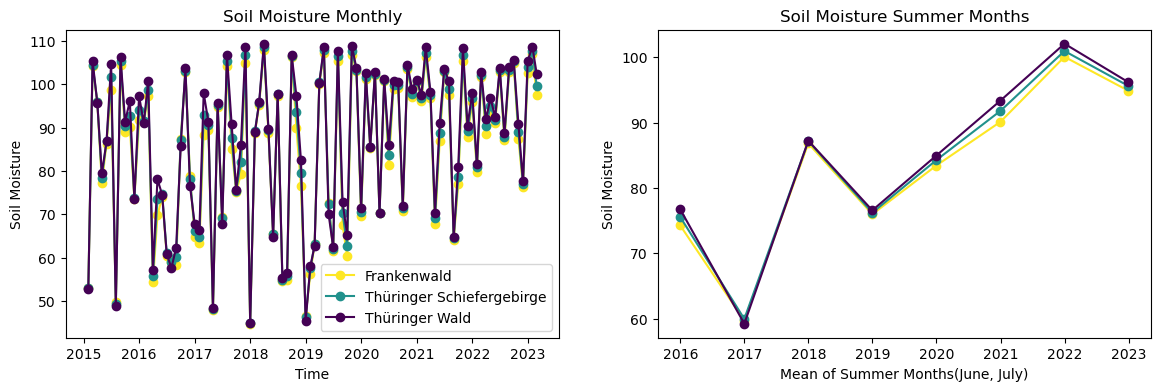

In [348]:
plot_time_series(mask_reprojected, sm_ds, "sm", "Soil Moisture","Time",'Soil Moisture Monthly',"Mean of Summer Months(June, July)", 'Soil Moisture Summer Months')


##### c. Precipitation 

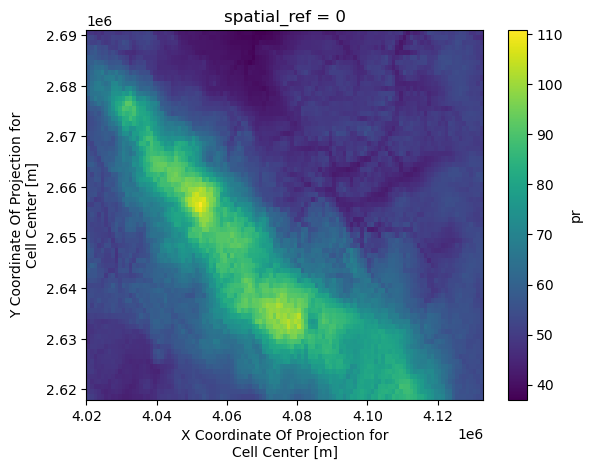

In [349]:
pr_ds = xr.open_dataset(path + 'SPEI/pr_rec.nc/', engine='netcdf4')
pr_ds.rio.write_crs("EPSG:3034", inplace=True)

mask_SPEI = mask
mask_SPEI.rio.write_crs("EPSG:4326", inplace=True)
mask_SPEI = mask.rio.reproject_match(pr_ds.rename({"lon": "x", "lat": "y"})).rename({"x": "lon", "y": "lat"})

pr_ds.pr.mean(dim='time').plot()

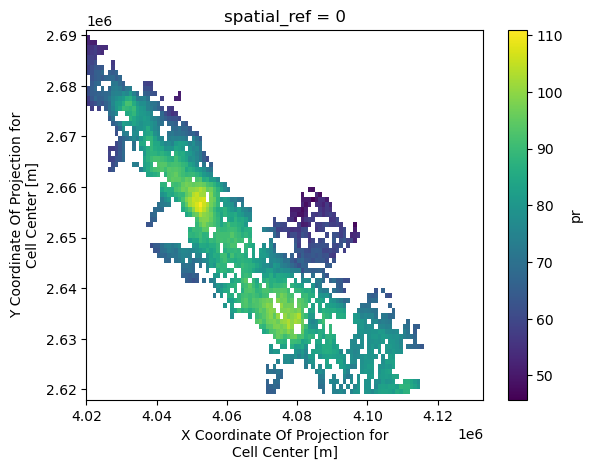

In [350]:
pr_ds.pr.mean(dim='time').where(mask_SPEI<4).plot()

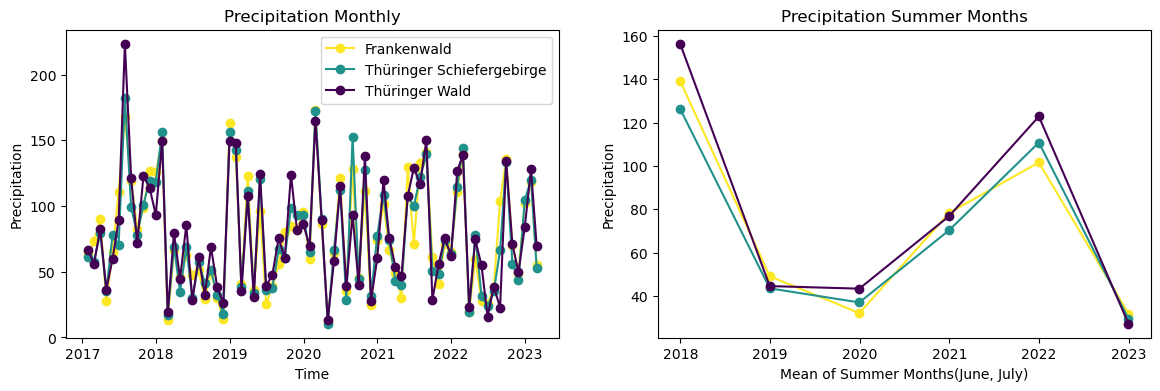

In [351]:
plot_time_series(mask_SPEI, pr_ds, "pr","Precipitation","Time",'Precipitation Monthly',"Mean of Summer Months(June, July)", 'Precipitation Summer Months')


In [352]:
pr_ds.sel(time=pr_ds.time.dt.month.isin([6,7]))

<xarray.Dataset>
Dimensions:      (lat: 73, lon: 113, time: 12)
Coordinates:
  * lat          (lat) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
  * lon          (lon) float32 4.02e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * time         (time) datetime64[ns] 2017-06-30 2017-07-31 ... 2022-07-31
    spatial_ref  int64 0
Data variables:
    pr           (time, lat, lon) float32 63.8 64.9 65.6 65.2 ... 41.0 43.2 41.8
Attributes: (12/22)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc
    units:                     mm
    _FillValue:                nan

##### d. Evapotranspiration

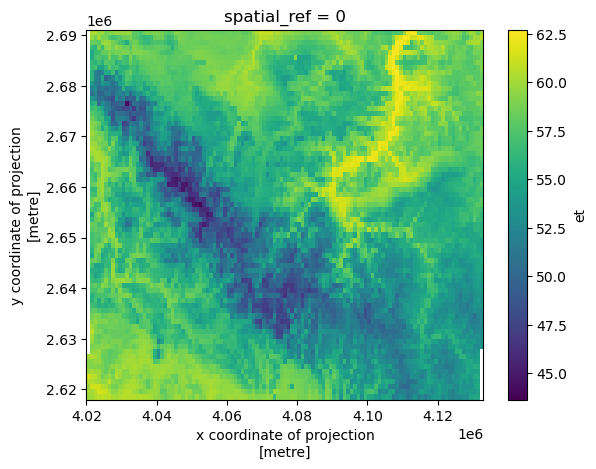

In [353]:
et_ds = xr.open_dataset(path + 'SPEI/et_rec.nc/', engine='netcdf4')
et_ds.rio.write_crs("EPSG:3034", inplace=True)
et_ds.et.mean(dim='time').plot()

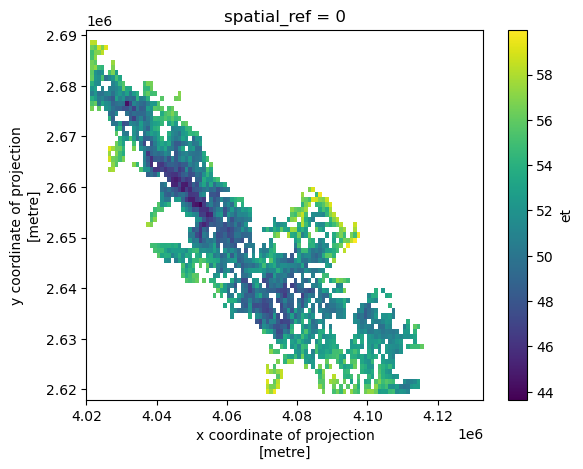

In [354]:
et_ds.et.mean(dim='time').where(mask_SPEI<4).plot()

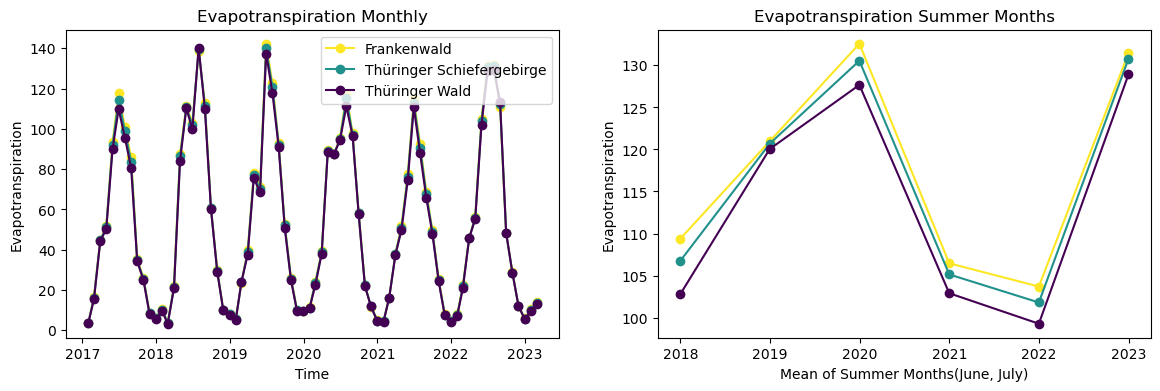

In [355]:
plot_time_series(mask_SPEI, et_ds, "et","Evapotranspiration","Time",'Evapotranspiration Monthly',"Mean of Summer Months(June, July)", 'Evapotranspiration Summer Months')

#### 3. Drought Indices

In [359]:
import scipy.stats as scs
def Calculate_SPI(pr_monthly, region_no,mask):
    pr = xarray_to_df(pr_monthly, region_no, mask)
    spi = si.spi(pr.iloc[:, 0].squeeze(), dist=scs.gamma)
    return spi

def Calculate_SPEI(pr, et, region_no,mask):
    pr = xarray_to_df(pr, region_no,mask)
    et = xarray_to_df(et, region_no,mask)
    pe = pr.iloc[:, 0].squeeze() - et.iloc[:, 0].squeeze()  # calculate precipitation excess
    spei = si.spei(pe)
    return spei

def xarray_to_df(ds_monthly, region_no,mask):
    region = ds_monthly.where(mask==region_no, other=np.nan)
    region = region.mean(dim=('lon', 'lat')).to_dataframe().reset_index().groupby(['time']).mean()
    region = region.dropna()
    return region


##### a. SPI

Text(0.5, 1.0, 'SPI')

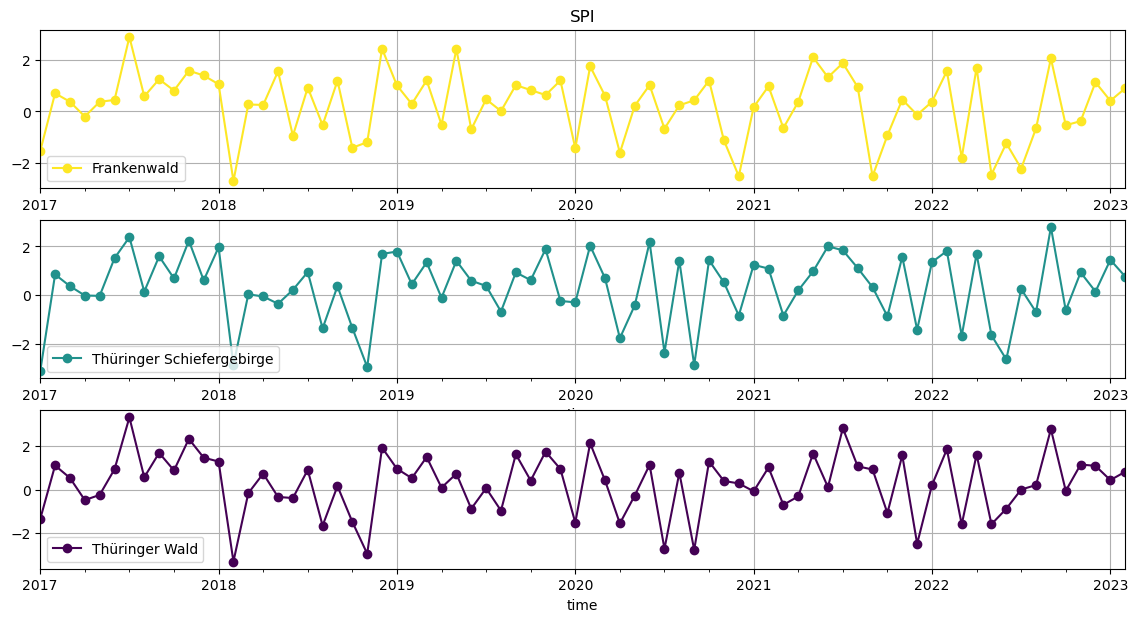

In [357]:
fig,(ax,ax2,ax3)=plt.subplots(3, 1, figsize=(14, 7))
spi1 = Calculate_SPI(pr_ds, 1, mask=mask_SPEI)
spi2 = Calculate_SPI(pr_ds, 2, mask=mask_SPEI)
spi3 = Calculate_SPI(pr_ds, 3, mask=mask_SPEI)
x =  pr_ds['time']
spi1.plot( ax=ax, marker='o', label="Frankenwald", color="#fde725", grid=True)
spi2.plot( ax=ax2, marker='o', label="Thüringer Schiefergebirge", color="#21918c", grid=True)
spi3.plot(  ax=ax3, marker='o', label="Thüringer Wald", color="#440154", grid=True)
ax.legend()
ax2.legend()
ax3.legend()
ax.set_title('SPI')


Text(0.5, 1.0, 'SPEI')

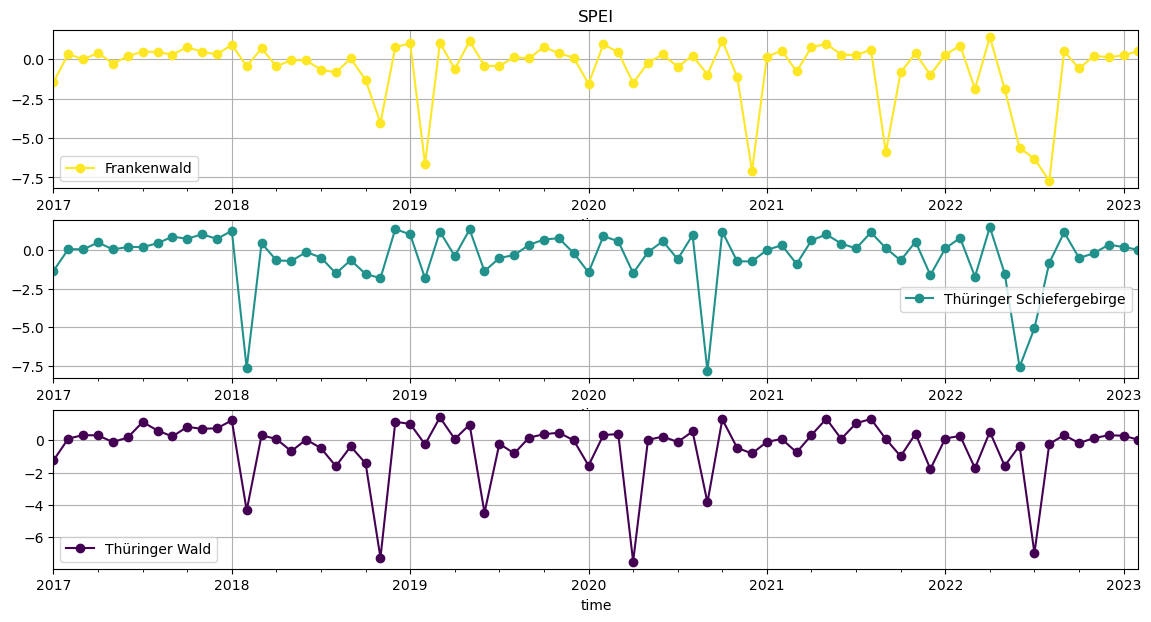

In [360]:
fig,(ax,ax2,ax3)=plt.subplots(3, 1, figsize=(14, 7))
spei1 = Calculate_SPEI(pr_ds, et_ds, 1, mask_SPEI)
spei2 = Calculate_SPEI(pr_ds, et_ds, 2, mask_SPEI)
spei3 = Calculate_SPEI(pr_ds, et_ds, 3, mask_SPEI)
x =  et_EPSG31467['time']
spei1.plot( ax=ax, marker='o', label="Frankenwald", color="#fde725", grid=True)
spei2.plot( ax=ax2, marker='o', label="Thüringer Schiefergebirge", color="#21918c", grid=True)
spei3.plot(  ax=ax3, marker='o', label="Thüringer Wald", color="#440154", grid=True)
ax.legend()
ax2.legend()
ax3.legend()
ax.set_title('SPEI')

In [ ]:
# import scipy.stats as scs
# pr_monthly = pr_ds.sortby('time').rolling(time=30, center=True).sum()
# pr_monthly = pr_monthly.resample(time='1M').mean()
# pr_monthly.pr.plot()
# pr_monthly2 = pr_ds.sortby('time').resample(time='1M').sum()
# pr_monthly2.pr.plot()

